In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


In [ ]:
data= pd.read_csv("bank.csv")

# check shape of dataset
print("shape of the data:", data.shape)
data.head()

shape of the data: (32950, 16)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


In [ ]:
# check data types of all columns
data.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

In [ ]:
data.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

In [ ]:
# target class count
data["y"].value_counts()

no     29238
yes     3712
Name: y, dtype: int64

Text(0.5, 1.0, 'target variable')

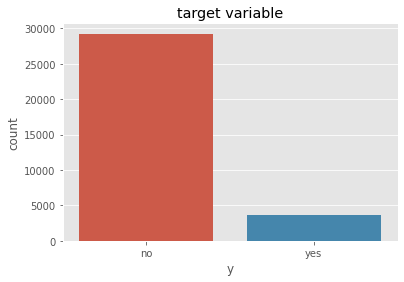

In [ ]:
sns.countplot(data["y"])
plt.title("target variable")

In [ ]:
# percentage of class present in target variable(y) 
print("percentage of NO and YES\n",data["y"].value_counts()/len(data)*100)

percentage of NO and YES
 no     88.734446
yes    11.265554
Name: y, dtype: float64


Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')


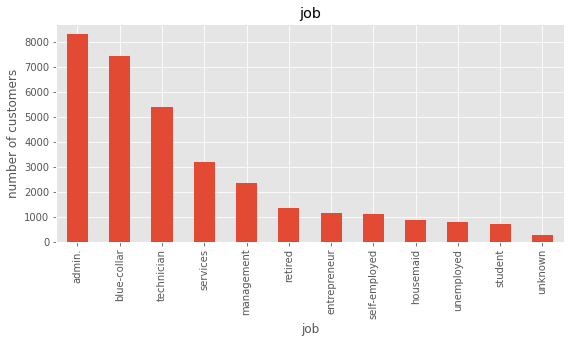

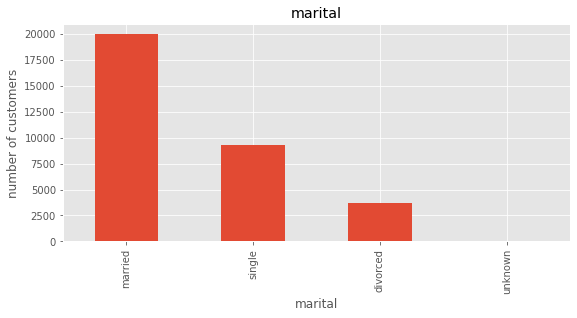

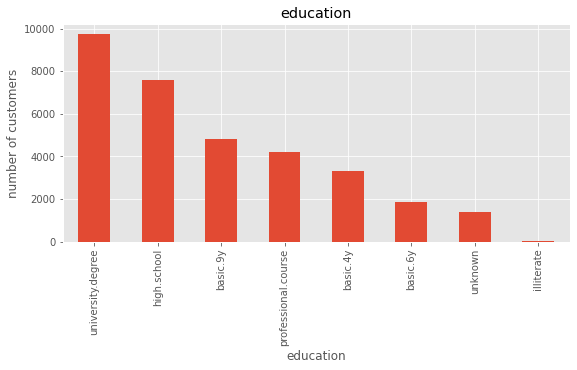

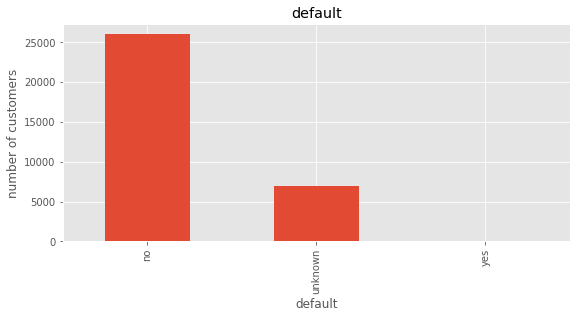

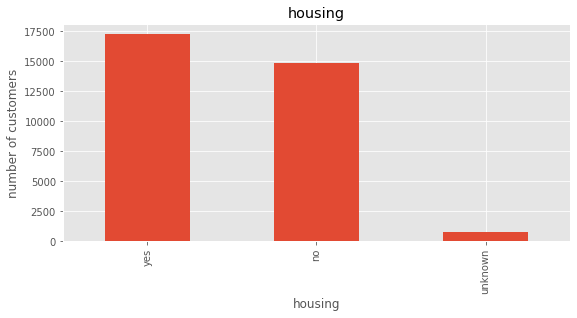

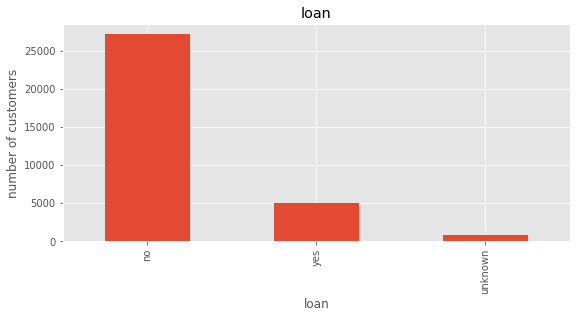

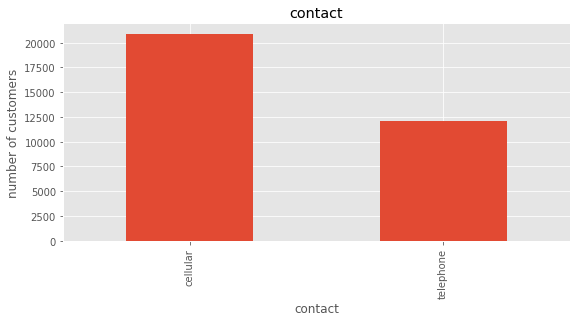

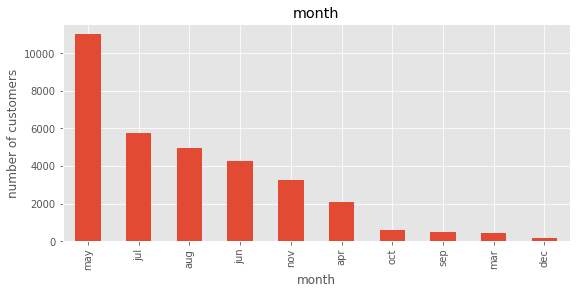

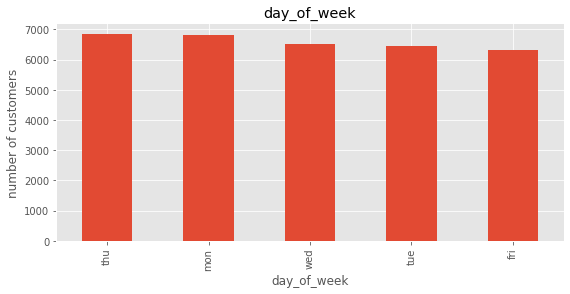

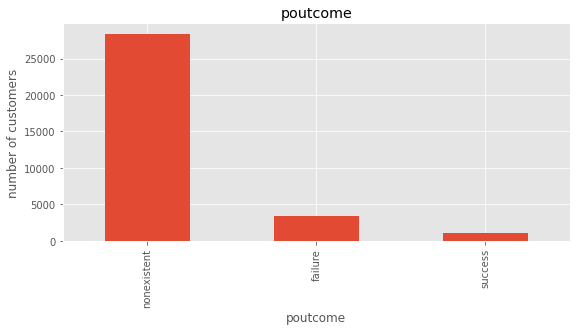

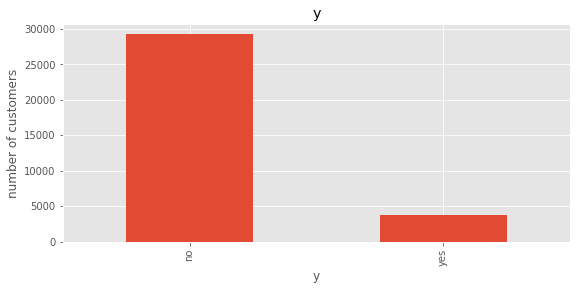

In [ ]:
# indentifying the categorical variables
cat_var= data.select_dtypes(include= ["object"]).columns
print(cat_var)

# plotting bar chart for each categorical variable
plt.style.use("ggplot")

for column in cat_var:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    data[column].value_counts().plot(kind="bar")
    plt.xlabel(column)
    plt.ylabel("number of customers")
    plt.title(column)

In [ ]:
# replacing "unknown" with the mode
for column in cat_var:
    mode= data[column].mode()[0]
    data[column]= data[column].replace("unknown", mode)

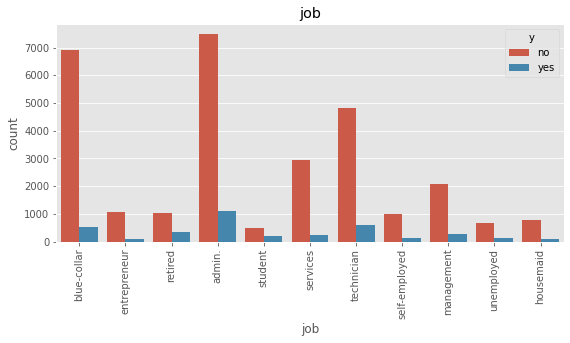

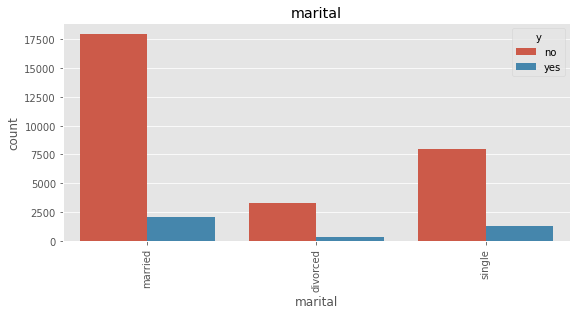

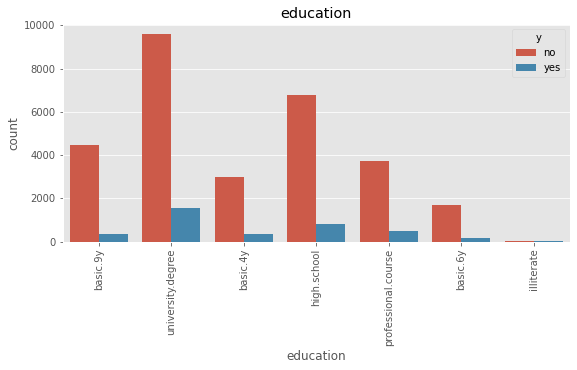

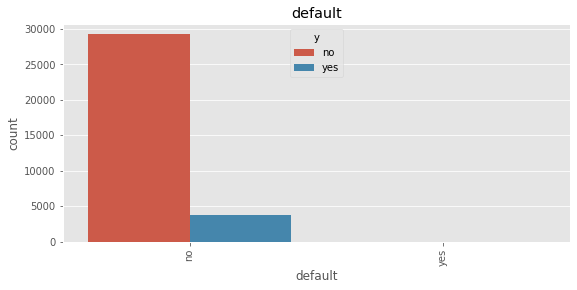

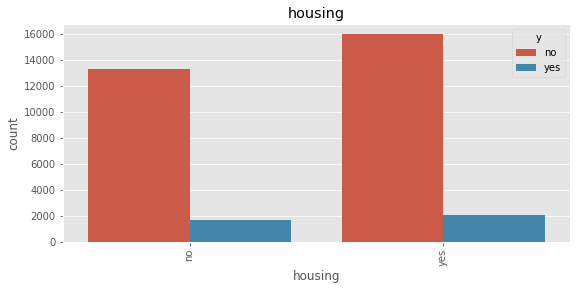

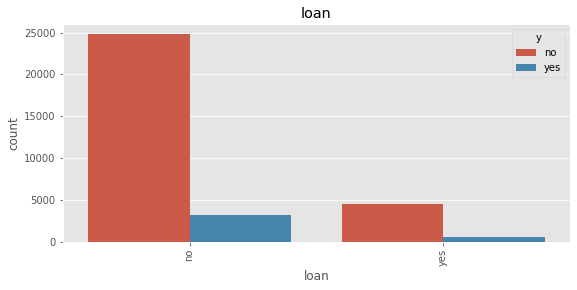

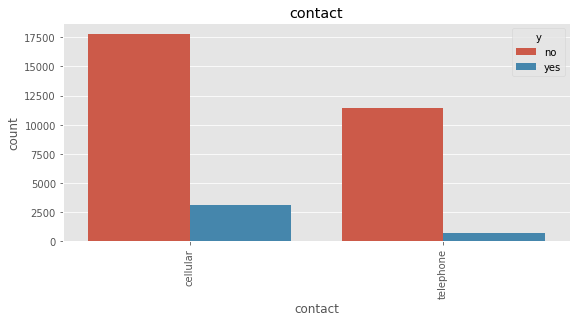

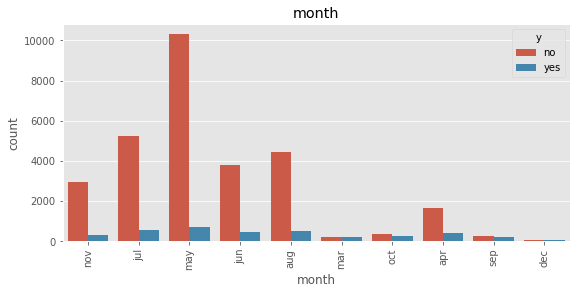

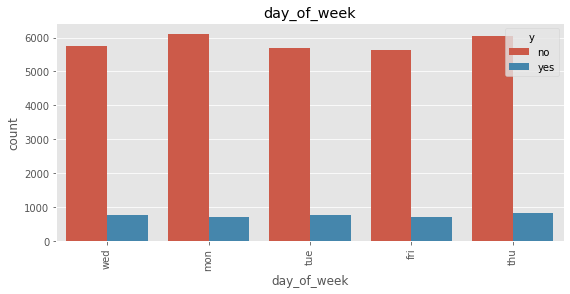

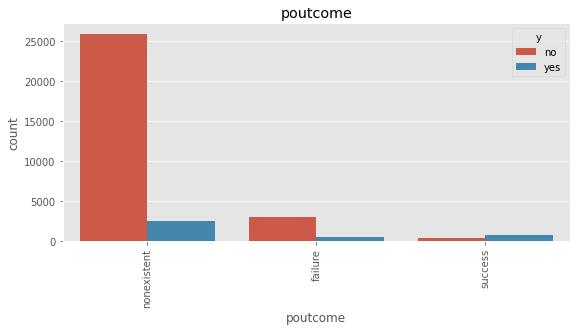

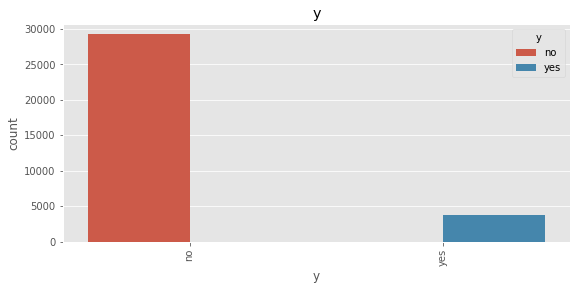

In [ ]:
plt.style.use("ggplot")
for column in cat_var:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.countplot(data[column], hue=data["y"])
    plt.title(column)    
    plt.xticks(rotation=90)

In [ ]:
# indentifying the numerical variables
num_var= data.select_dtypes(include=np.number)
num_var.head()

,age,duration,campaign,pdays,previous
0,49,227,4,999,0
1,37,202,2,999,1
2,78,1148,1,999,0
3,36,120,2,999,0
4,59,368,2,999,0


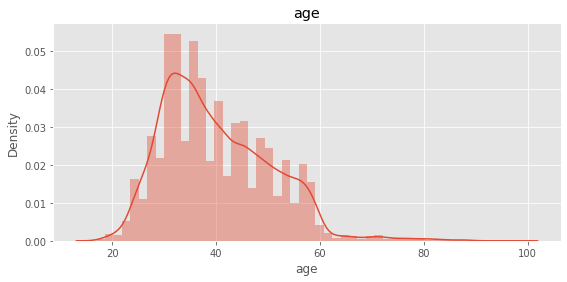

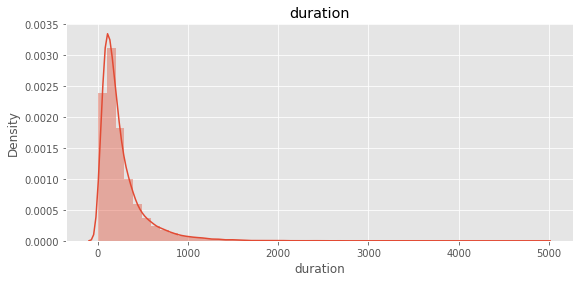

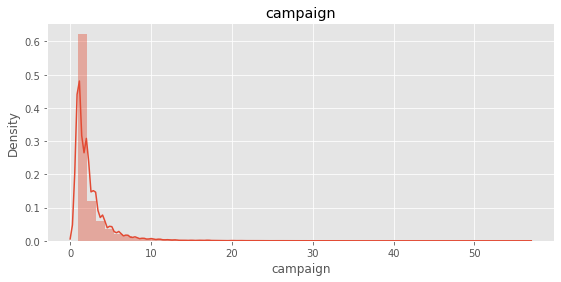

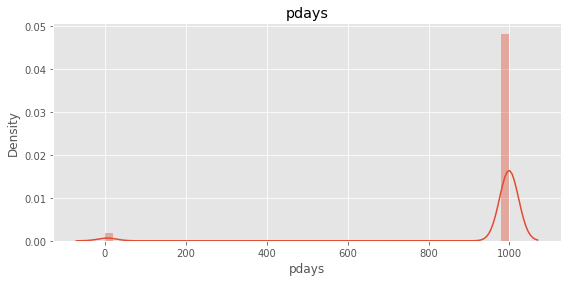

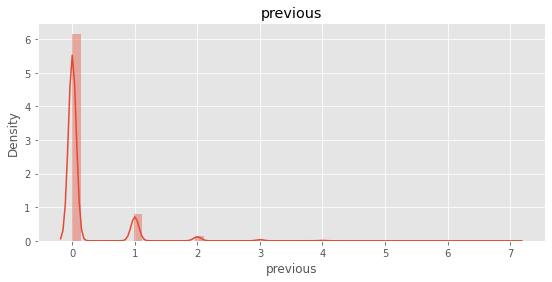

In [ ]:
# plotting histogram for each numerical variable
plt.style.use("ggplot")
for column in ["age", "duration", "campaign", "pdays", "previous"]:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.distplot(data[column], kde=True)
    plt.title(column)

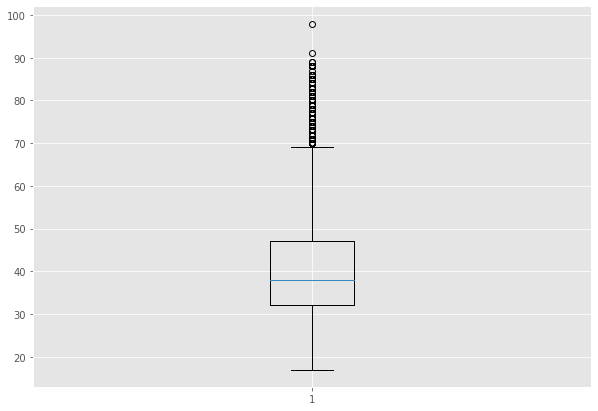

In [ ]:
age = data["age"]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(age)
 
# show plot
plt.show()

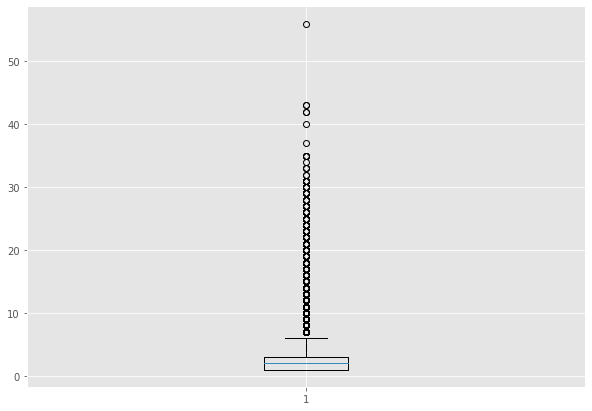

In [ ]:
campaign = data["campaign"]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(campaign)
 
# show plot
plt.show()

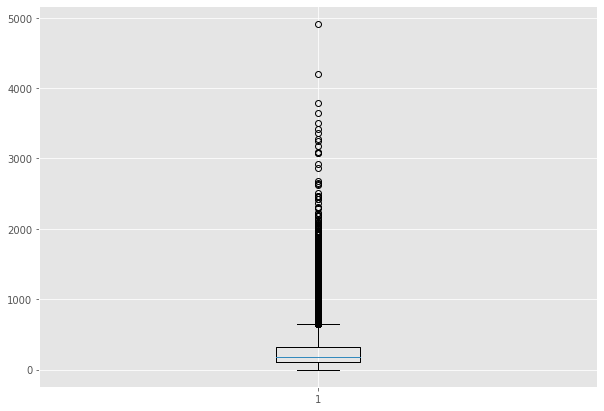

In [ ]:
duration = data["duration"]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(duration)
 
# show plot
plt.show()

In [ ]:
data.drop(columns=["pdays", "previous"], axis=1, inplace=True)

In [ ]:
data.describe()

,age,duration,campaign
count,32950.000000,32950.000000,32950.000000
mean,40.014112,258.127466,2.560607
std,10.403636,258.975917,2.752326
min,17.000000,0.000000,1.000000
25%,32.000000,103.000000,1.000000
50%,38.000000,180.000000,2.000000
75%,47.000000,319.000000,3.000000
max,98.000000,4918.000000,56.000000


In [ ]:
# compute interquantile range to calculate the boundaries
lower_boundries= []
upper_boundries= []
for i in ["age", "duration", "campaign"]:
    IQR= data[i].quantile(0.75) - data[i].quantile(0.25)
    lower_bound= data[i].quantile(0.25) - (1.5*IQR)
    upper_bound= data[i].quantile(0.75) + (1.5*IQR)
    
    print(i, ":", lower_bound, ",",  upper_bound)
    
    lower_boundries.append(lower_bound)
    upper_boundries.append(upper_bound)

age : 9.5 , 69.5
duration : -221.0 , 643.0
campaign : -2.0 , 6.0


In [ ]:
lower_boundries

[9.5, -221.0, -2.0]

In [ ]:
upper_boundries

[69.5, 643.0, 6.0]

In [ ]:
# replace the all the outliers which is greater then upper boundary by upper boundary
j = 0
for i in ["age", "duration", "campaign"]:
    data.loc[data[i] > upper_boundries[j], i] = int(upper_boundries[j])
    j = j + 1  

In [ ]:
# without outliers
data.describe()

,age,duration,campaign
count,32950.000000,32950.000000,32950.000000
mean,39.929894,234.923915,2.271077
std,10.118566,176.854558,1.546302
min,17.000000,0.000000,1.000000
25%,32.000000,103.000000,1.000000
50%,38.000000,180.000000,2.000000
75%,47.000000,319.000000,3.000000
max,69.000000,643.000000,6.000000


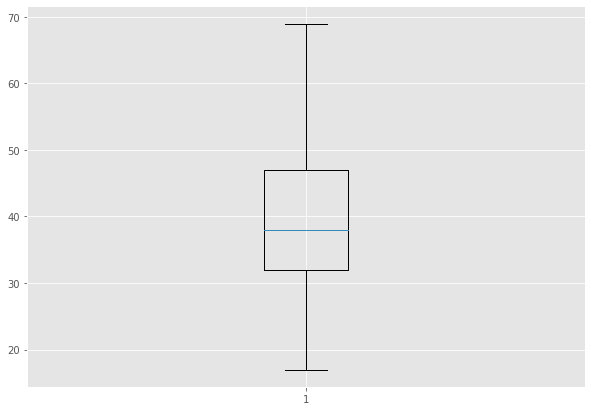

In [ ]:
age = data["age"]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(age)
 
# show plot
plt.show()

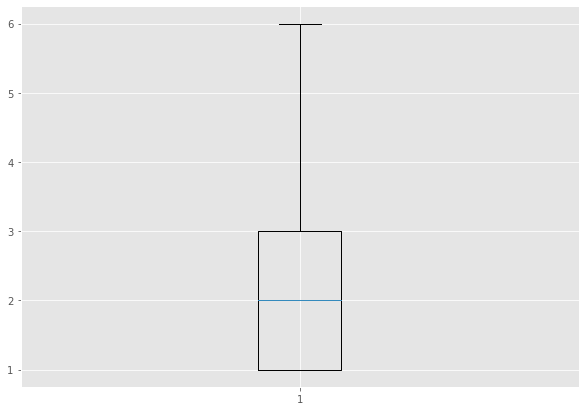

In [ ]:
campaign = data["campaign"]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(campaign)
 
# show plot
plt.show()

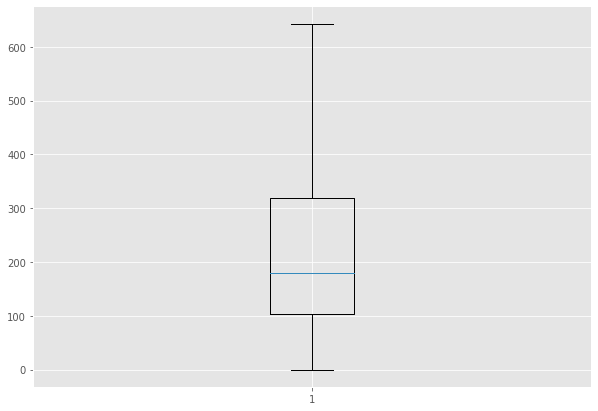

In [ ]:
duration = data["duration"]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(duration)
 
# show plot
plt.show()

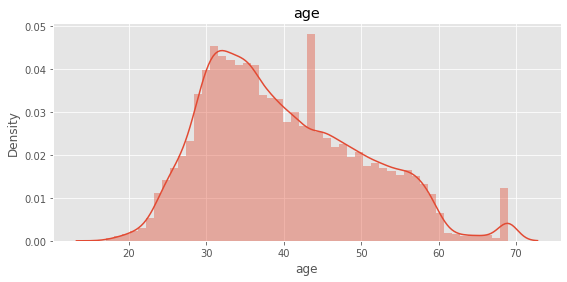

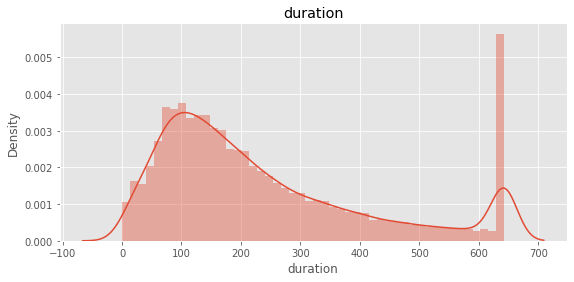

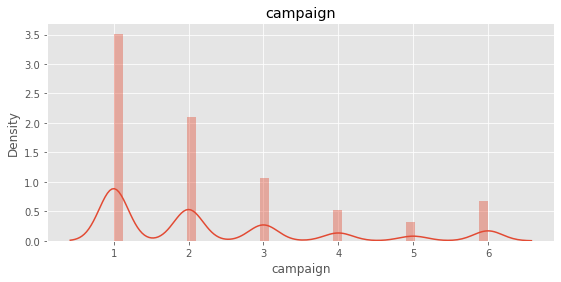

In [ ]:
# plotting histogram for each numerical variable
plt.style.use("ggplot")
for column in ["age", "duration", "campaign"]:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.distplot(data[column], kde=True)
    plt.title(column)

In [ ]:
#categorical features
cat_var

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [ ]:
# check categorical class
for i in cat_var:
    print(i, ":", data[i].unique())

job : ['blue-collar' 'entrepreneur' 'retired' 'admin.' 'student' 'services'
 'technician' 'self-employed' 'management' 'unemployed' 'housemaid']
marital : ['married' 'divorced' 'single']
education : ['basic.9y' 'university.degree' 'basic.4y' 'high.school'
 'professional.course' 'basic.6y' 'illiterate']
default : ['no' 'yes']
housing : ['no' 'yes']
loan : ['no' 'yes']
contact : ['cellular' 'telephone']
month : ['nov' 'jul' 'may' 'jun' 'aug' 'mar' 'oct' 'apr' 'sep' 'dec']
day_of_week : ['wed' 'mon' 'tue' 'fri' 'thu']
poutcome : ['nonexistent' 'failure' 'success']
y : ['no' 'yes']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# initializing label encoder
le= LabelEncoder()

# iterating through each categorical feature and label encoding them
for feature in cat_var:
    data[feature]= le.fit_transform(data[feature])

In [ ]:
# label encoded dataset
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y
0,49,1,1,2,0,0,0,0,7,4,227,4,1,0
1,37,2,1,6,0,0,0,1,7,4,202,2,0,0
2,69,5,1,0,0,0,0,0,3,1,643,1,1,1
3,36,0,1,6,0,1,0,1,6,1,120,2,1,0
4,59,5,0,6,0,0,0,0,4,3,368,2,1,0


In [ ]:
# feature variables
x= data.iloc[:, :-1]

# target variable
y= data.iloc[:, -1]

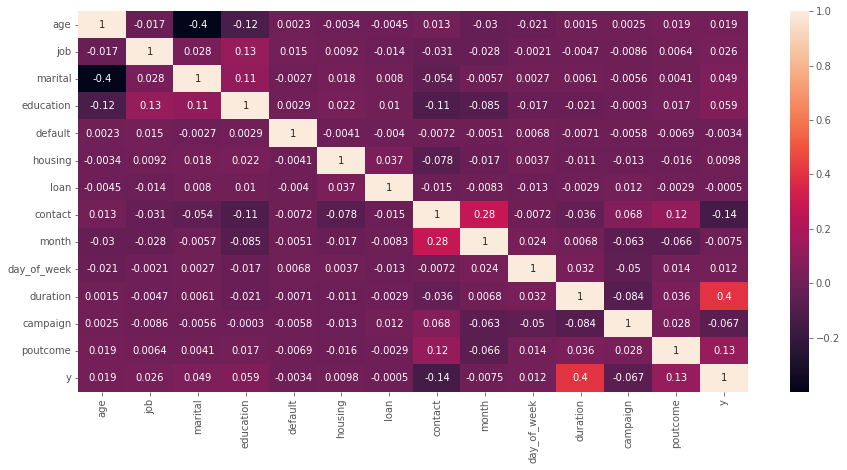

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(data.corr(), annot=True)

In [ ]:
#initialising oversampling
smote= SMOTETomek(0.75)

#implementing oversampling to training data
x_sm, y_sm= smote.fit_resample(x,y)

# x_sm and y_sm are the resampled data

# target class count of resampled dataset
y_sm.value_counts()

0    28961
1    21651
Name: y, dtype: int64

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(x_sm, y_sm, test_size=0.2, random_state=42)

In [ ]:
# selecting the classifier
log_reg= LogisticRegression()

# selecting hyperparameter tuning
log_param= {"C": 10.0**np.arange(-2,3), "penalty": ["l1", "l2"]}

# defining stratified Kfold cross validation
cv_log= StratifiedKFold(n_splits=5)

# using gridsearch for respective parameters
gridsearch_log= GridSearchCV(log_reg, log_param, cv=cv_log, scoring= "f1_macro", n_jobs=-1, verbose=2)

# fitting the model on resampled data
gridsearch_log.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro', verbose=2)

Accuracy of Logistic Regression: 0.797095722611874
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      5813
           1       0.78      0.73      0.75      4310

    accuracy                           0.80     10123
   macro avg       0.79      0.79      0.79     10123
weighted avg       0.80      0.80      0.80     10123



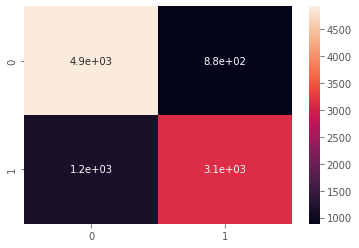

In [ ]:
# checking model performance
y_predicted= gridsearch_log.predict(x_test)

cm= confusion_matrix(y_test, y_predicted)
sns.heatmap(cm, annot=True)
print("Accuracy of Logistic Regression:",accuracy_score(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

In [ ]:
# random forest
rf= RandomForestClassifier()

rf_param= { 
           "n_estimators": [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
           "max_features": ["auto", "sqrt", "log2"],
#            "max_depth": [4,5,6,7,8],
           "max_depth": [int(x) for x in np.linspace(start=5, stop=30, num=6)],
           "min_samples_split": [5,10,15,100],
           "min_samples_leaf": [1,2,5,10],
           "criterion":['gini', 'entropy'] 
          }

cv_rf= StratifiedKFold(n_splits=5)

randomsearch_rf= RandomizedSearchCV(rf, rf_param, cv=cv_rf, scoring= "f1_macro", n_jobs=-1, verbose=2, n_iter=10)

randomsearch_rf.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   scoring='f1_macro', verbose=2)

Accuracy of Random Forest Model: 0.9015114096611676
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      5813
           1       0.87      0.91      0.89      4310

    accuracy                           0.90     10123
   macro avg       0.90      0.90      0.90     10123
weighted avg       0.90      0.90      0.90     10123



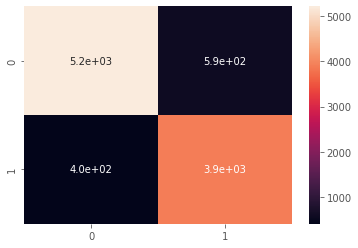

In [ ]:
# checking model performance
y_predicted_rf= randomsearch_rf.predict(x_test)
sns.heatmap(confusion_matrix(y_test, y_predicted_rf), annot=True)
print("Accuracy of Random Forest Model:",accuracy_score(y_test, y_predicted_rf))
print(classification_report(y_test, y_predicted_rf))

In [ ]:
#Artificial Neural Network
ANN_Classifier=Sequential()
ANN_Classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 13))
ANN_Classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
ANN_Classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
ANN_Classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ANN_Classifier.fit(x_train, y_train, batch_size = 10, epochs = 20)
ANN_Classifier.predict(x_test)


Epoch 1/20
4049/4049 [==============================] - 12s 3ms/step - loss: 0.4667 - accuracy: 0.7735
Epoch 2/20
4049/4049 [==============================] - 11s 3ms/step - loss: 0.4201 - accuracy: 0.8025
Epoch 3/20
4049/4049 [==============================] - 12s 3ms/step - loss: 0.4162 - accuracy: 0.8027
Epoch 4/20
4049/4049 [==============================] - 11s 3ms/step - loss: 0.4157 - accuracy: 0.8046
Epoch 5/20
4049/4049 [==============================] - 11s 3ms/step - loss: 0.4135 - accuracy: 0.8044
Epoch 6/20
4049/4049 [==============================] - 11s 3ms/step - loss: 0.4121 - accuracy: 0.8046
Epoch 7/20
4049/4049 [==============================] - 22s 5ms/step - loss: 0.4115 - accuracy: 0.8041
Epoch 8/20
4049/4049 [==============================] - 11s 3ms/step - loss: 0.4093 - accuracy: 0.8072
Epoch 9/20
4049/4049 [==============================] - 11s 3ms/step - loss: 0.4089 - accuracy: 0.8056
Epoch 10/20
4049/4049 [==============================] - 11s 3ms/step - l

array([[0.23497224],
       [0.00383079],
       [0.21346164],
       ...,
       [0.6979944 ],
       [0.33189636],
       [0.9060904 ]], dtype=float32)

Accuracy of ANN Model: 0.8073693569100069
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      5813
           1       0.76      0.80      0.78      4310

    accuracy                           0.81     10123
   macro avg       0.80      0.81      0.80     10123
weighted avg       0.81      0.81      0.81     10123



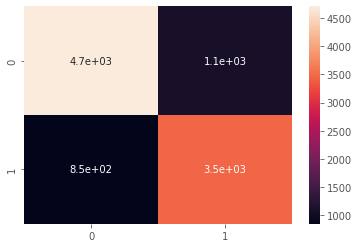

In [ ]:
y_predicted_rf= ANN_Classifier.predict(x_test)
y_predicted_rf = (y_predicted_rf > 0.5)
confusion_matrix(y_test, y_predicted_rf)
sns.heatmap(confusion_matrix(y_test, y_predicted_rf), annot=True)
print("Accuracy of ANN Model:",accuracy_score(y_test, y_predicted_rf))
print(classification_report(y_test, y_predicted_rf))

In [ ]:
test_data= pd.read_csv("bank_test.csv")
test_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
0,32,4,0,6,0,0,0,0,3,3,131,5,1
1,37,10,3,6,0,0,0,0,4,3,100,1,1
2,55,5,0,5,1,2,0,0,3,2,131,2,1
3,44,2,1,0,1,0,0,1,4,3,48,2,1
4,28,0,2,3,0,0,0,0,5,0,144,2,1


In [ ]:
x_test = x_test.to_numpy()
x_train = x_train.to_numpy()

In [ ]:
x_train.shape

(40489, 13)

In [ ]:
x_train  = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
batch_size = 32

In [ ]:
#LSTM Model
model = Sequential()
model.add(LSTM(4,input_dim=13))  
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4)                 288       
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_13 (Dense)            (None, 1)                 5         
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 293
Trainable params: 293
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
checkpointer = callbacks.ModelCheckpoint(filepath="checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
model.fit(x_train, y_train, batch_size=batch_size, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1266/1266 [==============================] - 10s 5ms/step - loss: 0.6076 - accuracy: 0.6864 - val_loss: 0.5762 - val_accuracy: 0.7382
Epoch 2/10
1266/1266 [==============================] - 5s 4ms/step - loss: 0.5486 - accuracy: 0.7322 - val_loss: 0.5092 - val_accuracy: 0.7435
Epoch 3/10
1266/1266 [==============================] - 5s 4ms/step - loss: 0.4973 - accuracy: 0.7574 - val_loss: 0.4687 - val_accuracy: 0.7746
Epoch 4/10
1266/1266 [==============================] - 5s 4ms/step - loss: 0.4753 - accuracy: 0.7766 - val_loss: 0.4476 - val_accuracy: 0.7915
Epoch 5/10
1266/1266 [==============================] - 6s 4ms/step - loss: 0.4681 - accuracy: 0.7765 - val_loss: 0.4479 - val_accuracy: 0.7837
Epoch 6/10
1266/1266 [==============================] - 6s 4ms/step - loss: 0.4651 - accuracy: 0.7744 - val_loss: 0.4394 - val_accuracy: 0.7781
Epoch 7/10
1266/1266 [==============================] - 6s 5ms/step - loss: 0.4609 - accuracy: 0.7628 - val_loss: 0.4372 - val_accuracy

317/317 [==============================] - 1s 3ms/step - loss: 0.4300 - accuracy: 0.7998
Accuracy of LSTM Model: 79.98%
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      5813
           1       0.75      0.79      0.77      4310

    accuracy                           0.80     10123
   macro avg       0.80      0.80      0.80     10123
weighted avg       0.80      0.80      0.80     10123



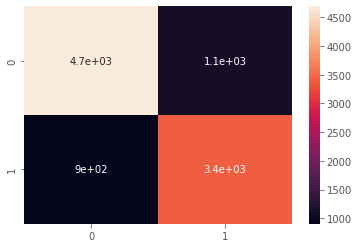

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Accuracy of LSTM Model: %.2f%%" % ( accuracy*100))
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)
confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test, y_pred))

In [ ]:
training_set, test_set = train_test_split(data, test_size = 0.2, random_state = 1)

In [ ]:
x_train = training_set.iloc[:,0:13].values
y_train = training_set.iloc[:,13].values
x_test = test_set.iloc[:,0:13].values
y_test = test_set.iloc[:,13].values

In [ ]:
#SVM Model
classifier = SVC(kernel='rbf', random_state = 1)
classifier.fit(x_train,y_train)

SVC(random_state=1)

In [ ]:
y_pred = classifier.predict(x_test)

In [ ]:
test_set["Predictions"] = y_pred


Accuracy Of SVM For The Given Dataset :  0.887556904400607
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5849
           1       0.00      0.00      0.00       741

    accuracy                           0.89      6590
   macro avg       0.44      0.50      0.47      6590
weighted avg       0.79      0.89      0.83      6590



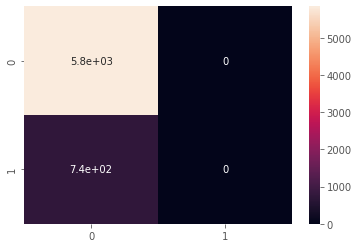

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
accuracy = float(cm.diagonal().sum())/len(y_test)
print("\nAccuracy Of SVM For The Given Dataset : ", accuracy)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test, y_pred))

In [ ]:
# predicting the test data
y_predicted= randomsearch_rf.predict(test_data)
y_predicted

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
# dataset of predicted values for target variable y
prediction= pd.DataFrame(y_predicted, columns=["y_predicted"])
prediction_dataset= pd.concat([test_data, prediction], axis=1)
prediction_dataset['y_predicted'] = prediction_dataset['y_predicted'].map({1: 'yes', 0: 'no'})
prediction_dataset.to_csv('Output.csv')
prediction_dataset

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y_predicted
0,32,4,0,6,0,0,0,0,3,3,131,5,1,no
1,37,10,3,6,0,0,0,0,4,3,100,1,1,no
2,55,5,0,5,1,2,0,0,3,2,131,2,1,no
3,44,2,1,0,1,0,0,1,4,3,48,2,1,no
4,28,0,2,3,0,0,0,0,5,0,144,2,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8233,48,4,1,2,0,2,0,0,6,3,554,1,1,yes
8234,30,7,2,3,0,2,0,0,6,0,159,1,1,no
8235,33,7,1,3,0,0,0,0,4,1,472,1,0,yes
8236,44,1,1,1,0,2,2,1,6,1,554,5,1,no
